In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
headings = ['Building Identifier',
            'Country',
             'City',
             'Quality / Stage of Data',
             'Construction Date',
             'Building Type',
             'Contributor']

In [2]:
df = pd.read_excel('Dataset/dataset.xlsx',header=1,usecols='B:BKX')

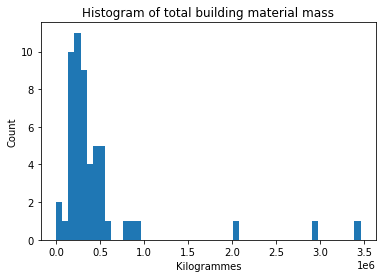

In [17]:
plt.hist(df[[c for c in df.columns if 'kg' in c]].sum(axis=1),bins=50);
plt.title('Histogram of total building material mass')
plt.xlabel('Kilogrammes')
plt.ylabel('Count');

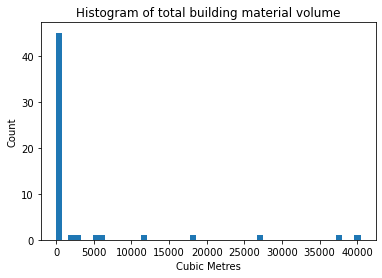

In [18]:
plt.hist(df[[c for c in df.columns if 'm3' in c]].sum(axis=1),bins=50);
plt.title('Histogram of total building material volume')
plt.xlabel('Cubic Metres')
plt.ylabel('Count');

In [32]:
for k,v in df.groupby('Building Type'):
    print(f'{k}: {len(v)} buildings')
    print(f'Average year: {int(v["Construction Date"].mean())}')
    print()

APB: 2 buildings
Average year: 2014

EDU: 2 buildings
Average year: 2016

INS: 1 buildings
Average year: 1988

MIX: 1 buildings
Average year: 2018

OFF: 3 buildings
Average year: 2009

ROW: 1 buildings
Average year: 2018

SMD: 4 buildings
Average year: 1994

SND: 40 buildings
Average year: 2015



In [48]:
for k,v in df.groupby('Construction Date'):
    print(f'{k}: {len(v)} buildings')
    print('Most used materials:')
    print([t[0] for t in sorted(v[[t for t in v.columns if t not in headings]].sum().items(),key=lambda x:x[1], reverse=True)[0:3]])
    print()

1913: 1 buildings
Most used materials:
['B01_A1010.10.0FW_03 31 16.00_kg_1', 'B01_A4090.60.000_32 11 23.00_kg_1', 'B01_A4010.10.000_03 31 16.00_kg_1']

1917: 1 buildings
Most used materials:
['B01_A1010.10.0FW_03 31 16.00_kg_1', 'B01_A4090.60.000_32 11 23.00_kg_1', 'B01_A4010.10.000_03 31 16.00_kg_1']

1969: 2 buildings
Most used materials:
['B01_A1010.10.0FW_03 31 16.00_kg_1', 'B01_A4090.60.000_32 11 23.00_kg_2', 'B01_A4010.10.000_03 31 16.00_kg_2']

1988: 1 buildings
Most used materials:
['000_B1010.10.FGB_03 21 00.00_kg_3', '00F_A1010.30.0SF_03 21 00.00_kg_3', 'P01_A5010.20.000_03 21 00.00_kg_3']

2007: 1 buildings
Most used materials:
['999_C1010.10.000_03 21 00.00_kg_3', '000_B1010.20.000_03 21 00.00_kg_3', '000_A1020.20.000_03 21 00.00_kg_3']

2009: 1 buildings
Most used materials:
['000_B1010.20.000_03 21 00.00_kg_3', 'P02_A5010.20.000_03 21 00.00_kg_3', 'P01_A5010.20.000_03 21 00.00_kg_3']

2011: 2 buildings
Most used materials:
['004_B1020.10.RGB_05 12 00.00_kg_1', '001_B1010.